In [1]:
import pandas as pd
test_df = pd.read_csv('/home/yupaporn/code/Defect-Detection-2024/Dataset_Annotation_defect_Boxes_lab_v2_cropImg.csv')
test_df = test_df.drop(columns=['Unnamed: 0'])
print(test_df.shape)
test_df.head()

(238, 17)


,image_id,width,height,file_name,area,bbox,set,img_path,xmin,ymin,xmax,ymax,img_path_cropped,pred_xmin,pred_ymin,pred_xmax,pred_ymax
0,1,1108,1477,D01.jpg,1975.3272,"[409.33, 228.21, 64.68, 30.54]",Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,409.33,228.21,474.01,258.75,/media/HDD/dataset_cctv_plate/data_defect/lab_...,[232.17092895507812],[70.09832000732422],[855.486083984375],[1391.1435546875]
1,1,1108,1477,D01.jpg,1859.5500,"[633.93, 228.21, 57.5, 32.34]",Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,633.93,228.21,691.43,260.55,/media/HDD/dataset_cctv_plate/data_defect/lab_...,[232.17092895507812],[70.09832000732422],[855.486083984375],[1391.1435546875]
2,1,1108,1477,D01.jpg,1259.1040,"[332.06, 215.63, 26.95, 46.72]",Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,332.06,215.63,359.01,262.35,/media/HDD/dataset_cctv_plate/data_defect/lab_...,[232.17092895507812],[70.09832000732422],[855.486083984375],[1391.1435546875]
3,1,1108,1477,D01.jpg,4048.6626,"[423.7, 382.73, 39.53, 102.42]",Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,423.70,382.73,463.23,485.15,/media/HDD/dataset_cctv_plate/data_defect/lab_...,[232.17092895507812],[70.09832000732422],[855.486083984375],[1391.1435546875]
4,2,1108,1477,D03.jpg,12149.4434,"[400.52, 770.67, 127.58, 95.23]",Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,400.52,770.67,528.10,865.90,/media/HDD/dataset_cctv_plate/data_defect/lab_...,[69.17632293701172],[400.9124450683594],[986.4578247070312],[1286.888671875]


In [2]:
df = test_df

In [3]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import ast

In [12]:
image_path = list(set(df['img_path_cropped']))
res = []
for i in range(len(image_path)):
    #[1]
    cropped_img_path = image_path[i]
    cropped_img = cv2.imread(cropped_img_path)
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    height_c, width_c , _  = cropped_img.shape
    #[2]
    tb = df[df['img_path_cropped'] == cropped_img_path]
    image_id = tb['image_id'].tolist()
    width_ = tb['width'].tolist()
    height_ = tb['height'].tolist()
    file_name = tb['file_name'].tolist()
    set_ = tb['set'].tolist()
    img_path = tb['img_path'].tolist()

    crop_xmin, crop_ymin, crop_xmax, crop_ymax = float(list(tb['pred_xmin'])[0].split('[')[1].split(']')[0]),float(list(tb['pred_ymin'])[0].split('[')[1].split(']')[0]),float(list(tb['pred_xmax'])[0].split('[')[1].split(']')[0]),float(list(tb['pred_ymax'])[0].split('[')[1].split(']')[0])
    #[3]-Iterate over bounding boxes
    original_bboxes = []
    for index in range(len(tb)):
        bbox = ast.literal_eval(tb['bbox'].iloc[index])  # Extract bounding box coordinates

        xmin = int(bbox[0])
        ymin = int(bbox[1])
        width = int(bbox[2])
        height = int(bbox[3])
        xmax = xmin + width
        ymax = ymin + height

        original_bboxes.append((xmin, ymin, xmax, ymax))
    #[4]-Calculate new bounding box coordinates for the cropped image
    adjusted_bboxes = []
    for (xmin, ymin, xmax, ymax) in original_bboxes:
        new_xmin = max(xmin - crop_xmin, 0)
        new_ymin = max(ymin - crop_ymin, 0)
        new_xmax = min(xmax - crop_xmin, crop_xmax - crop_xmin)
        new_ymax = min(ymax - crop_ymin, crop_ymax - crop_ymin)

        adjusted_bboxes.append((round(new_xmin), round(new_ymin), round(new_xmax), round(new_ymax)))

    for j in range(len(adjusted_bboxes)):
        new_xmin = adjusted_bboxes[j][0]
        new_ymin = adjusted_bboxes[j][1]
        new_xmax = adjusted_bboxes[j][2]
        new_ymax = adjusted_bboxes[j][3]
        w = new_xmax - new_xmin
        h = new_ymax - new_ymin
        box_ = [new_xmin, new_ymin, new_xmax, new_ymax]
        box_wh = [new_xmin, new_ymin, w, h]
        res.append({'image_id':image_id[j], 'width':width_[j], 'height':height_[j], 'file_name':file_name[j], 'set':set_[j], 
                    'img_path':img_path[j], 'xmin_cropped':new_xmin, 'ymin_cropped': new_ymin, 'xmax_cropped':new_xmax, 
                    'ymax_cropped':new_ymax, 'img_path_cropped':cropped_img_path, 'width_cropped':width_c, 
                    'height_cropped':height_c,'height_imgcropped':h,'height_imgcropped':w,'bboxx':box_,'bboxx_wh':box_wh})

In [13]:
df_res = pd.DataFrame(res)
df_res

,image_id,width,height,file_name,set,img_path,xmin_cropped,ymin_cropped,xmax_cropped,ymax_cropped,img_path_cropped,width_cropped,height_cropped,height_imgcropped,bboxx,bboxx_wh
0,42,1478,1108,D59.jpg,Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,511,869,556,932,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1087,1017,45,"[511, 869, 556, 932]","[511, 869, 45, 63]"
1,20,1477,1108,D27.jpg,Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,718,443,770,530,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1033,995,52,"[718, 443, 770, 530]","[718, 443, 52, 87]"
2,34,1108,1477,D47.jpg,Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,368,297,389,318,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1070,1049,21,"[368, 297, 389, 318]","[368, 297, 21, 21]"
3,34,1108,1477,D47.jpg,Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,473,279,487,295,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1070,1049,14,"[473, 279, 487, 295]","[473, 279, 14, 16]"
4,33,1108,1477,D45.jpg,Train,/media/HDD/dataset_cctv_plate/data_defect/lab_...,346,265,365,288,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1089,1096,19,"[346, 265, 365, 288]","[346, 265, 19, 23]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,19,1108,1477,D65.jpg,Test,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1017,1138,1058,1199,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1068,1447,41,"[1017, 1138, 1058, 1199]","[1017, 1138, 41, 61]"
234,19,1108,1477,D65.jpg,Test,/media/HDD/dataset_cctv_plate/data_defect/lab_...,694,812,986,1119,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1068,1447,292,"[694, 812, 986, 1119]","[694, 812, 292, 307]"
235,19,1108,1477,D65.jpg,Test,/media/HDD/dataset_cctv_plate/data_defect/lab_...,627,818,675,843,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1068,1447,48,"[627, 818, 675, 843]","[627, 818, 48, 25]"
236,19,1108,1477,D65.jpg,Test,/media/HDD/dataset_cctv_plate/data_defect/lab_...,112,325,496,675,/media/HDD/dataset_cctv_plate/data_defect/lab_...,1068,1447,384,"[112, 325, 496, 675]","[112, 325, 384, 350]"


In [14]:
df_res.to_csv('/home/yupaporn/code/Defect-Detection-2024/Dataset_Annotation_defect_Boxes_lab_v2_cropImg_cropped.csv')

In [7]:
# test  

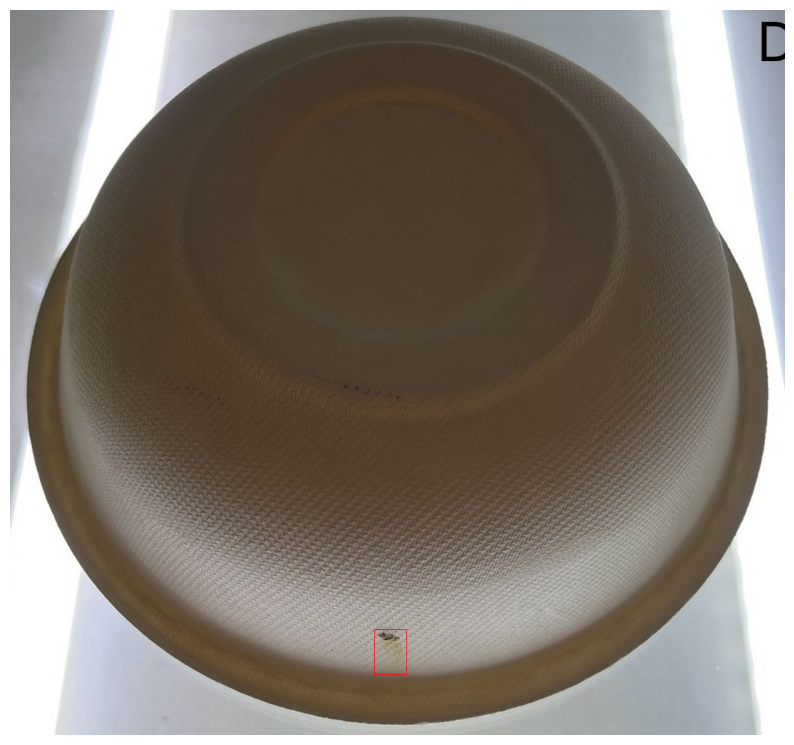

In [8]:
# xmin_, ymin_, xmax_, ymax_ = [], [], [], []
# Define the image path for plotting
image_path = list(set(df_res['img_path_cropped']))

# Load the original image (to get dimensions)
cropped_img_path = image_path[0]

cropped_img = cv2.imread(cropped_img_path)
cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

tb = df_res[df_res['img_path_cropped'] == cropped_img_path]
xmin = tb['xmin_cropped'].tolist()
ymin = tb['ymin_cropped'].tolist()
xmax = tb['xmax_cropped'].tolist()
ymax = tb['ymax_cropped'].tolist()
for i in range(len(tb)):
    cv2.rectangle(cropped_img, (xmin[i], ymin[i]), (xmax[i], ymax[i]), (255, 0, 0), 1)  # Red box

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(cropped_img)
plt.axis('off')
plt.show()


In [ ]:
#------------------------------------------------------------------------------------------------------------------------